In [20]:
import pandas as pd
import numpy as np

In [72]:
L='nktr aig luv pch wdc nclh celg dwdp spxc ame xyl stt r akam reg dov xray chd apc'.upper().split(' ')

Merge the price data the same way as the quote and ask data, while for the size variable we sum over each 10 second period.

In [73]:
df=pd.read_csv('11011116_vwap.csv',header=0)


C:\Users\DR\AppData\Local\Programs\Python\Python36\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [74]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

def VWAP_calc(ticker,capital):
    df_t=df[df['SYM_ROOT']==ticker]
    D=sorted(list(set(df_t['DATE'])))
    St=[]
    S_t=[]
    for d in D[:-1]:
        i=-1
        s=[]
        T=[]
        df_d=df_t[df_t['DATE']==d]
        for j in range(len(df_d['TIME_M'])):
            
            if len(T)>0 and (int(np.array(df_d['TIME_M'])[j][-15:-13])-int(T[-1][-2:]))>1:
                    s.append(0)
                   
            if np.array(df_d['TIME_M'])[j][:-13] not in T:
                i+=1
                T.append(np.array(df_d['TIME_M'])[j][:-13])
                s.append(np.array(df_d['SIZE'])[j])
            else:
                s[i]+=np.array(df_d['SIZE'])[j]
        if '9:30' not in T:
            s=[0]+s
            
        if len(s)==30:
            St+=s
            S_t.append(s)
    St=np.array(St,dtype=float)
    S_t=np.array(S_t,dtype=float)
    for i in range(len(S_t)):
        S_t[i,:]=S_t[i,:]/float(np.sum(S_t[i,:]))
    hist_mean=np.mean(S_t,axis=0)
    T=[]
    for i in range(int(len(St)/30)):
        for j in range(30):
            T.append(j)
    T=np.array(T)
    #print(T)
    X=[]
    for i in range(len(T)):
        t=T[i]
        X.append([t,t**2,t**3,t**4,t**5])
    X=np.array(X)
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X,St)
    pred_vol=regr.predict(X[:30,:])
    
    pred_mean=pred_vol/np.sum(pred_vol)
    #print(vol_mean)
    df_d=df_t[df_t['DATE']==D[0]]
    T=[]
    s_start=[]
    p_start=[]
    i=-1
    for j in range(len(df_d['TIME_M'])):
        
        if len(T)>0 and (int(np.array(df_d['TIME_M'])[j][-15:-13])-int(T[-1][-2:]))>1:
            
                s_start.append(0)
                p_start.append(p_start[-1])
        if np.array(df_d['TIME_M'])[j][:-13] not in T:
            
            i+=1
            T.append(str(np.array(df_d['TIME_M'])[j][:-13]))
            p_start.append(np.array(df_d['PRICE'])[j])
            s_start.append(np.array(df_d['SIZE'])[j])
        else:
            s_start[i]+=np.array(df_d['SIZE'])[j]
    if '9:30' not in T:
        s_start=[0]+s_start
        p_start=[0]+p_start
    df_d=df_t[df_t['DATE']==D[-1]]
    T=[]
    s_end=[]
    p_end=[]
    i=-1
    for j in range(len(df_d['TIME_M'])):
        
        if len(T)>0 and (int(np.array(df_d['TIME_M'])[j][-15:-13])-int(T[-1][-2:]))>1:
           
                s_end.append(0)
                p_end.append(p_end[-1])
        if np.array(df_d['TIME_M'])[j][:-13] not in T:
            i+=1
            T.append(str(np.array(df_d['TIME_M'])[j][:-13]))
            p_end.append(np.array(df_d['PRICE'])[j])
            s_end.append(np.array(df_d['SIZE'])[j])
        else:
            s_end[i]+=np.array(df_d['SIZE'])[j]
    if '9:30' not in T:
        s_end=[0]+s_end
        p_end=[0]+p_end
    #print(T)
    Dict_=np.load('data.npy').item()
    p_d=np.array(Dict_[ticker.lower()]['Open'])[23]
    p_s=np.array(Dict_[ticker.lower()]['Open'])[34]
    cap=capital
    size=int(cap/p_d)
    hb,r,pb=execution(hist_mean,size,s_start,p_start)
    size=int(cap/p_d)
    hs,r,ps=execution(hist_mean,size,s_end,p_end)
    size=int(cap/p_d)
    hb,r,pb2=execution(pred_mean,size,s_start,p_start)
    size=int(cap/p_d)
    hs,r,ps2=execution(pred_mean,size,s_end,p_end)
    h,bb=benchmark(size,s_start,p_start)
    h,bs=benchmark(size,s_end,p_end)
    print('2018.11.01 (Buy)Decision Price:'+str(p_d)+' Executed VWAP(historic mean):'+str(round(pb,3))+' Executed VWAP(fitted mean):'+str(round(pb2,3))+' Benchmark VWAP:'+str(round(bb,3)))
    print('2018.11.16 (Sell)Decision Price:'+str(p_s)+' Executed VWAP(historic mean):'+str(round(ps,3))+' Executed VWAP(fitted mean):'+str(round(ps2,3))+' Benchmark VWAP:'+str(round(bs,3)))
    print('IS1:'+str(((pb-p_d)*size+(p_s-ps)*size)/float(capital))+' IS2:'+str(((pb2-p_d)*size+(p_s-ps2)*size)/float(capital)))
    return St,(size*ps-size*pb)/(size*pb),hb,hs,pb,ps,bb,bs,((bb-p_d)*size+(p_s-bs)*size)/float(capital),((pb-p_d)*size+(p_s-ps)*size)/float(capital),((pb2-p_d)*size+(p_s-ps2)*size)/float(capital)

In [75]:
shortfall=[]
shortfall2=[]
benchmark_sf=[]
for i in set(L):
  
    print(i)
    record=VWAP_calc(i,L.count(i)*100000)
    IS=record[-1]
    IS2=record[-2]
    bm=record[-3]
    shortfall.append(IS)
    shortfall2.append(IS2)
    benchmark_sf.append(bm)

AKAM
2018.11.01 (Buy)Decision Price:71.85 Executed VWAP(historic mean):71.962 Executed VWAP(fitted mean):71.951 Benchmark VWAP:71.833
2018.11.16 (Sell)Decision Price:69.39 Executed VWAP(historic mean):69.234 Executed VWAP(fitted mean):69.207 Benchmark VWAP:69.301
IS1:0.003732634078860226 IS2:0.003947816022025522
XRAY
2018.11.01 (Buy)Decision Price:34.5789 Executed VWAP(historic mean):34.825 Executed VWAP(fitted mean):34.839 Benchmark VWAP:34.815
2018.11.16 (Sell)Decision Price:36.8536 Executed VWAP(historic mean):37.018 Executed VWAP(fitted mean):37.016 Benchmark VWAP:36.926
IS1:0.002373906543783157 IS2:0.0028354054759991026
WDC
2018.11.01 (Buy)Decision Price:42.7434 Executed VWAP(historic mean):43.802 Executed VWAP(fitted mean):43.828 Benchmark VWAP:43.823
2018.11.16 (Sell)Decision Price:45.6731 Executed VWAP(historic mean):46.245 Executed VWAP(fitted mean):46.245 Benchmark VWAP:46.255
IS1:0.01138660820381659 IS2:0.01198960708014233
APC
2018.11.01 (Buy)Decision Price:52.5223 Executed 

In [76]:
print('Period Theoretical Return:'+str(0.04577343961148787))
print('Historic mean Shortfall:'+str(np.mean(shortfall2)))
print('Fitted mean Shortfall:'+str(np.mean(shortfall)))
print('Benchmark Shortfall:'+str(np.mean(benchmark_sf)))

Period Theoretical Return:0.04577343961148787
Historic mean Shortfall:0.01362785238137555
Fitted mean Shortfall:0.013693282743646059
Benchmark Shortfall:0.014813505427366725


In [34]:
def execution(target_percentage,size,real_volume,real_price):
    i=0
    VWAP=0
    size_=size
    history=[]
    while size>0 and i<len(real_volume):
        goal=target_percentage[i]*size_
        if i==len(real_volume)-1:
            
            realized=min(size,real_volume[i])
        else:
            realized=min(goal,real_volume[i])
        realized=min(realized,size)
        VWAP+=realized*real_price[i]
        history.append(realized)
        
        i+=1
        size-=realized
    history=np.array(history)
    return history,size,VWAP/float(np.sum(history))
def benchmark(size,real_volume,real_price):
    history=np.array(real_volume)*size/float(sum(real_volume))
    VWAP=np.sum(history*np.array(real_price))
    return history,VWAP/float(np.sum(history))


# Plotting cumulative volume percentage distribution

In [49]:

try:    
    df_t=df[df['SYM_ROOT']==L[1]]
    D=list(set(df_t['DATE']))
    St=[]
    S_t=[]
    for d in D[:-1]:
        i=-1
        s=[]
        T=[]
        df_d=df_t[df_t['DATE']==d]
        for j in range(len(df_d['TIME_M'])):
            
            if len(T)>0 and (int(np.array(df_d['TIME_M'])[j][-15:-13])-int(T[-1][-2:]))>1:
                    s.append(0)
                   
            if np.array(df_d['TIME_M'])[j][:-13] not in T:
                i+=1
                T.append(np.array(df_d['TIME_M'])[j][:-13])
                s.append(np.array(df_d['SIZE'])[j])
            else:
                s[i]+=np.array(df_d['SIZE'])[j]
        if '9:30' not in T:
            s=[0]+s
            
        if len(s)==30:
            St+=s
            S_t.append(s)
    St=np.array(St,dtype=float)
    S_t=np.array(S_t,dtype=float)
    for i in range(len(S_t)):
        S_t[i,:]=S_t[i,:]/float(np.sum(S_t[i,:]))
    T=[]
    for i in range(int(len(St)/30)):
        for j in range(30):
            T.append(j)
    T=np.array(T)
    #print(T)
    X=[]
    for i in range(len(T)):
        t=T[i]
        X.append([t,t**2,t**3,t**4,t**5])
    X=np.array(X)
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X,St)
    pred_vol=regr.predict(X[:30,:])
    
    pred_mean=pred_vol/np.sum(pred_vol)
    vol_mean=np.mean(S_t,axis=0)
except:
    pass


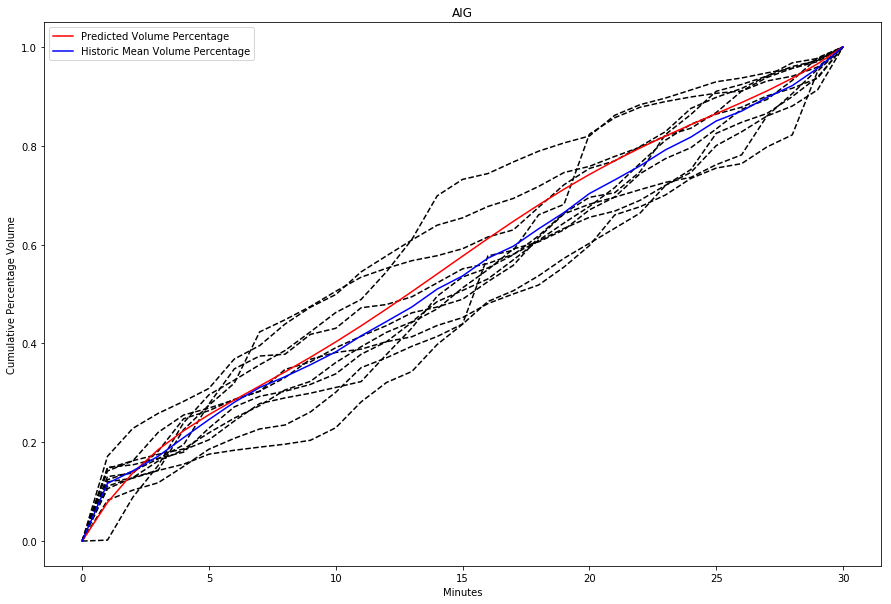

In [50]:
from matplotlib import pyplot as plt
%matplotlib inline
def plot_cumper(St,mean,pred,name):
    plt.figure(figsize=(15,10))
    for i in range(len(St)):
        c=[0]+[np.sum(St[i,:j+1]) for j in range(len(St[i]))]
        plt.plot(c,'k--')
    c=[0]+[np.sum(pred[:j+1]) for j in range(len(pred))]
    plt.plot(c,'r',label='Predicted Volume Percentage')
    c=[0]+[np.sum(mean[:j+1]) for j in range(len(mean))]
    plt.plot(c,'b',label='Historic Mean Volume Percentage')
    plt.title(name)
    plt.xlabel('Minutes')
    plt.ylabel('Cumulative Percentage Volume')
    plt.legend()
plot_cumper(S_t,vol_mean,pred_mean,L[1])